In [5]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split 
from tensorflow.keras.applications import EfficientNetB0
from keras.layers import GlobalAveragePooling2D,Dropout,Dense
from keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau,TensorBoard,ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import display,clear_output
import ipywidgets as widges
import io



In [6]:
labels=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
X_train = []
y_train = []
image_size=150
for i in labels:
    folderPath = os.path.join(r'/Users/saikeerthana/Downloads/Alzheimer_sDataset/','train',i)
    for j in tqdm(os.listdir(folderPath)):
        img= cv2.imread(os.path.join(folderPath,j))
        if img is not None:
            img =cv2.resize(img,(image_size,image_size))
            X_train.append(img)
            y_train.append(i)
for i in labels:
    folderPath = os.path.join(r'/Users/saikeerthana/Downloads/Alzheimer_sDataset/','test',i)
    for j in tqdm(os.listdir(folderPath)):
        img= cv2.imread(os.path.join(folderPath,j))
        if img is not None:
            img =cv2.resize(img,(image_size,image_size))
            X_train.append(img)
            y_train.append(i)

100%|███████████████████████████████████████| 448/448 [00:00<00:00, 3350.73it/s]


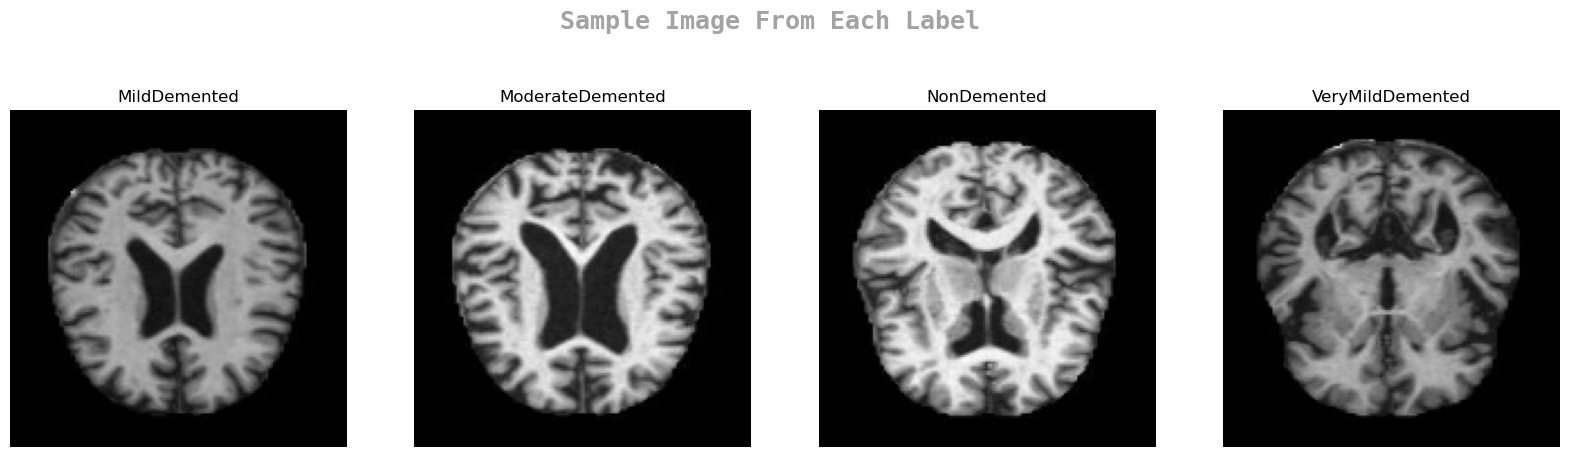

In [7]:
X_train = np.array(X_train)
y_train = np.array(y_train)
colors_dark = ['#28527a', '#8c8c8c', '#138a36', '#d63230']

k=0
fig, ax=plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True:
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1
#print(y_train[:60])

In [8]:
X_train,y_train=shuffle(X_train,y_train, random_state=101)
X_train.shape


(6400, 150, 150, 3)

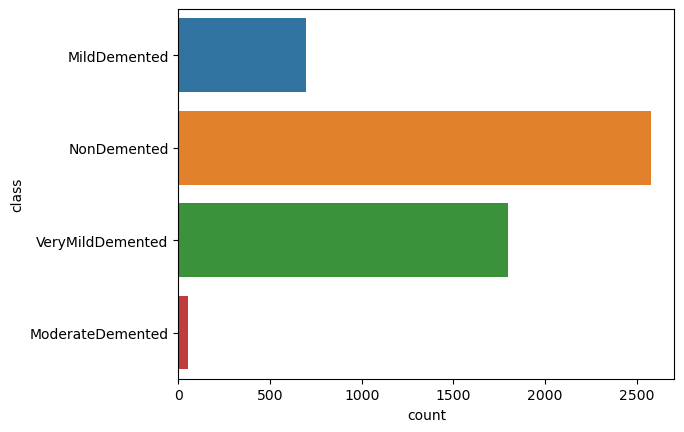

In [9]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.2,random_state=101)


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert y_train to a Pandas DataFrame
y_train_df = pd.DataFrame({'class': y_train})
#print(y_train_df)
# Plot the count distribution using Seaborn
sns.countplot(y='class', data=y_train_df)

# Show the plot
plt.show()


In [10]:
labels=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

y_train_new= []
for i in y_train:
    try:
        y_train_new.append(labels.index(i))
        
    except ValueError:
        print("Invalid label:", i)
    
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new=[]
for i in y_test:
    try:
        y_test_new.append(labels.index(i))
    except ValueError:
        print("Invalid label:", i)
y_test=y_test_new
y_test=tf.keras.utils.to_categorical(y_test)

In [11]:
from tensorflow.keras.applications import ResNet50

# Now you can use ResNet50
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Modify model layers for ResNet50
model = resnet.output
model = GlobalAveragePooling2D()(model)
model = Dropout(rate=0.5)(model)
model = Dense(4, activation='softmax')(model)
model = Model(inputs=resnet.input, outputs=model)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 156, 156, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 75, 75, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 75, 75, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 38, 38, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 38, 38, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 38, 38, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 19, 19, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 19, 19, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 19, 19, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 10, 10, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 10, 10, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 10, 10, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 10, 10, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 10, 10, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 10, 10, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 10, 10, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 10, 10, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 10, 10, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 10, 10, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 5, 5, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 5, 5, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 5, 5, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 5, 5, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [19]:
model.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])


In [13]:
reduce_lr=ReduceLROnPlateau(monitor='val_accuracy',factor=0.2,patience=2,min_delta= 0.001,mode='auto',verbose=1)

tensorboard=TensorBoard(log_dir='logs')
checkpoint=ModelCheckpoint("alzheimers-dataset-4-class-of images.h5", monitor='val_accuracy', save_best_only=True, mode='auto', verbose=1)

In [14]:
datagen= ImageDataGenerator(
featurewise_center=True, 
samplewise_center=False,
featurewise_std_normalization=True,
samplewise_std_normalization=False,
zca_whitening=False,
rotation_range=20,
zoom_range=0.2,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
horizontal_flip=True,
vertical_flip=True)
datagen.fit(X_train) 
history= model.fit(X_train,y_train,validation_split=0.2, epochs=15, verbose=1, batch_size=32,callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/15
128/128 [==============================] - ETA: 0s - loss: 1.1136 - accuracy: 0.5251
Epoch 1: val_accuracy improved from -inf to 0.50293, saving model to alzheimers-dataset-4-class-of images.h5
128/128 [==============================] - 295s 2s/step - loss: 1.1136 - accuracy: 0.5251 - val_loss: 26329.9727 - val_accuracy: 0.5029 - lr: 0.0010
Epoch 2/15
128/128 [==============================] - ETA: 0s - loss: 0.8506 - accuracy: 0.6084
Epoch 2: val_accuracy improved from 0.50293 to 0.57129, saving model to alzheimers-dataset-4-class-of images.h5
128/128 [==============================] - 311s 2s/step - loss: 0.8506 - accuracy: 0.6084 - val_loss: 2.3498 - val_accuracy: 0.5713 - lr: 0.0010
Epoch 3/15
128/128 [==============================] - ETA: 0s - loss: 0.6281 - accuracy: 0.7344
Epoch 3: val_accuracy did not improve from 0.57129
128/128 [==============================] - 332s 3s/step - loss: 0.6281 - accuracy: 0.7344 - val_loss: 2.8330 - val_accuracy: 0.3672 - lr: 0.0010
E

Text(0.5, 0, 'Epochs')

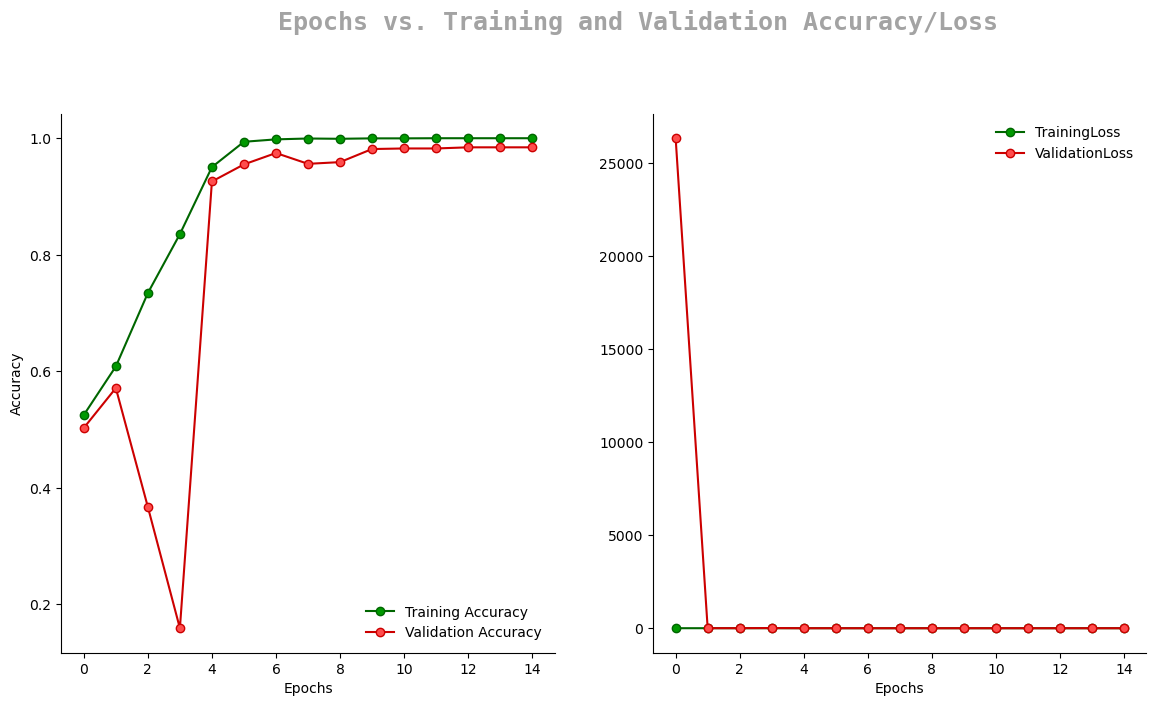

In [15]:
import warnings
warnings.filterwarnings('ignore')

epochs=[i for i in range(15)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss=history.history['loss'] 
val_acc=history.history['val_accuracy']
val_loss=history.history['val_loss']

colors_dark = ['#28527a', '#8c8c8c', '#138a36', '#d63230']
colors_green = ['#00FF00', '#00CC00', '#009900', '#006600']
colors_red = ['#ff0000','#a30000','#ff4d4d','#cc0000','#990000']
fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)
sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
label='Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
sns.despine()
ax[1].plot(epochs,train_loss,marker='o',markerfacecolor=colors_green[2],color=colors_green[3],label='TrainingLoss')
ax[1].plot(epochs, val_loss,marker='o',markerfacecolor=colors_red[2],color=colors_red[3],label = 'ValidationLoss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
# ax[1].set_ylabel('Training & ValidationLoss')

40/40 [==============================] - 20s 480ms/step
              precision    recall  f1-score   support

           0       0.97      0.92      0.95       198
           1       1.00      1.00      1.00        14
           2       0.99      0.98      0.98       624
           3       0.94      0.98      0.96       444

    accuracy                           0.97      1280
   macro avg       0.98      0.97      0.97      1280
weighted avg       0.97      0.97      0.97      1280



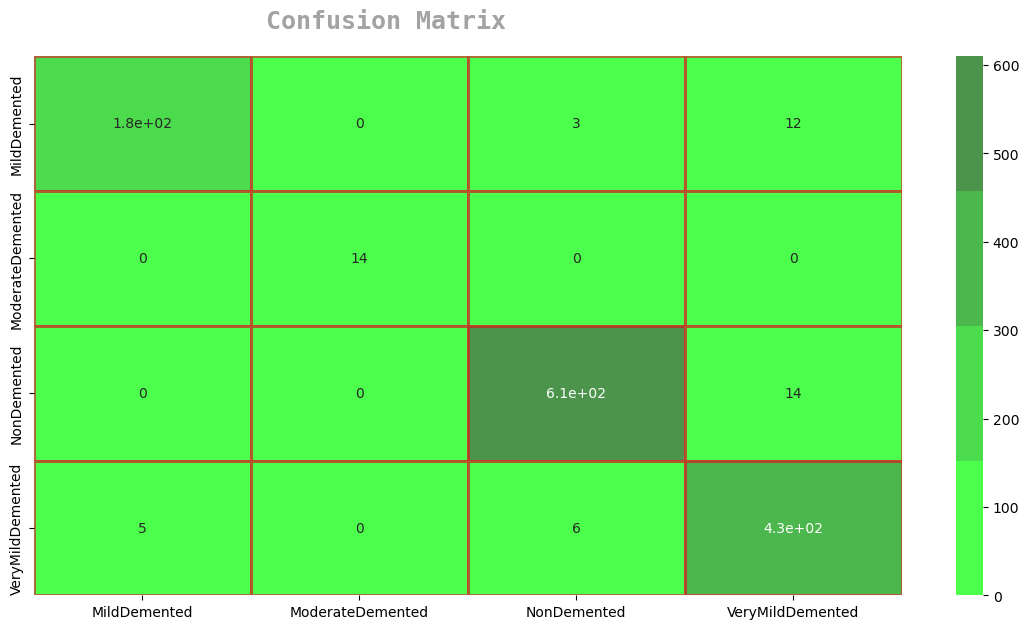

Accuracy: 96.88%


In [16]:
#testinng 
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)

y_test_new = np.argmax(y_test, axis=1)

# Ensure y_test_new and pred have the same number of samples
y_test_new = y_test_new[:len(pred)]

print(classification_report(y_test_new, pred))
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
sns.heatmap(confusion_matrix(y_test_new, pred), ax=ax, xticklabels=labels, yticklabels=labels, annot=True, cmap=colors_green[::1], alpha=0.7, linewidths=2, linecolor=colors_dark[3])
fig.text(s=' Confusion Matrix', size=18, fontweight='bold', fontname='monospace', color=colors_dark[1], y=0.92, x=0.28, alpha=0.8)

plt.show()

accuracy = np.sum(pred == y_test_new) / len(pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

In [22]:
import os
import io
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from ipywidgets import widgets
from IPython.display import display, clear_output

# Load the ResNet50 model
model = ResNet50(weights='imagenet', include_top=True)

# Define the directories for training and testing data
train_dir = os.path.join(r'/Users/saikeerthana/Downloads/Alzheimer_sDataset/','train')
test_dir = os.path.join(r'/Users/saikeerthana/Downloads/Alzheimer_sDataset/test')

# Load the training and testing data
train_data = image_dataset_from_directory(train_dir, image_size=(224, 224), label_mode="categorical", batch_size=32)
test_data = image_dataset_from_directory(test_dir, image_size=(224, 224), label_mode="categorical", batch_size=32)

# Function to predict image and show result
def img_pred(upload):
    for name, file_info in upload.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
        display(img)
        opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
        img = cv2.resize(opencvImage, (224, 224))
        img = preprocess_input(np.expand_dims(img, axis=0))
        pred = model.predict(img)
        decoded_predictions = tf.keras.applications.resnet50.decode_predictions(pred, top=1)[0]
        label = decoded_predictions[0][1]
        print(f'The model predicts that it is a {label}')
        pred_label = np.argmax(pred, axis=1)[0]
        if pred_label == 0:
            pred_text = 'Mild Demented'
        elif pred_label == 1:
            pred_text = 'Moderate Demented'
        elif pred_label == 2:
            pred_text = 'Non Demented'
        else:
            pred_text = 'Very Mild Demented'
        print(f'The model predicts that it is a {pred_text}')
        height,width, channels=150,150,3
        print(f'Prediction from CNN:{pred_text}')
        perturbations = generate_adversary(img, pred).numpy()
        adversarial = img + (perturbations * 0.5)
        fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8, 4))
        ax1.imshow(img[0].reshape(150,150,3))
        ax1.set_title("Original Image")
        ax2.imshow(adversarial[0])
        ax2.set_title("Image with Adversary")
        plt.show()

def generate_adversary(image, label):
    image = tf.cast(image, tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(image) 
        prediction = model(image)
        loss = tf.keras.losses.MSE(label, prediction)
        gradient = tape.gradient(loss, image)
        sign_grad = tf.sign(gradient)
    return sign_grad

# Create file upload widget and button for prediction
uploader = widgets.FileUpload()
display(uploader)
button = widgets.Button(description='Predict')
out = widgets.Output()

# Define the function to run on button click
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)
        except:
            print('No Image Uploaded/Invalid Image File')

# Attach function to button click event
button.on_click(on_button_clicked)

# Display the button and output widget
widgets.VBox([button, out])


Found 5121 files belonging to 4 classes.
Found 1279 files belonging to 4 classes.


FileUpload(value=(), description='Upload')

In [27]:
import tensorflow as tf
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import backend as K
from random import randint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report
import numpy as np

# Assuming you have a model with a final dense layer that outputs the number of classes
NUM_CLASSES = model.layers[-1].output_shape[-1]

def generate_adversary(image, label):
    # Convert NumPy array to TensorFlow tensor
    image = tf.convert_to_tensor(image, dtype=tf.float32)

    # Assume label is not one-hot encoded
    one_hot_label = tf.one_hot(label, depth=NUM_CLASSES)

    # Calculate the loss
    loss_object = CategoricalCrossentropy()
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = loss_object(one_hot_label, prediction)

    # Calculate gradients of the loss with respect to the input image
    gradient = tape.gradient(loss, image)

    # Normalize the gradient
    gradient /= (K.sqrt(K.mean(K.square(gradient))) + 1e-8)

    # Generate perturbations based on the normalized gradient
    perturbations = 0.1 * gradient

    # Ensure perturbations have the same shape as the input image
    perturbations = tf.image.resize(perturbations, (224, 224))

    return perturbations

def adversary_generator(batch_size):
    while True:
        images = []
        labels = []
        for _ in range(batch_size):
            N = randint(0, len(X_train) - 1)
            label = y_train[N]
            image = X_train[N].reshape((1, 150, 150, 3))
            
            # Convert label to integer
            label_int = int(label[0])  # Assuming label is an array

            images.append(image)
            labels.append(label_int)

        images = np.asarray(images).reshape((batch_size, 150, 150, 3))
        labels = to_categorical(np.asarray(labels), num_classes=NUM_CLASSES)
        yield images, labels

# Resize the adversarial data to match the input shape of the model
x_adversarial_resized = tf.image.resize(x_adversarial, (224, 224))
y_adversarial_resized = y_adversarial  # Labels remain unchanged

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=2, min_delta=0.001, mode='auto', verbose=1)
checkpoint = ModelCheckpoint("alzheimers-dataset-4-class-of images.h1", monitor='val_accuracy', save_best_only=True, mode='auto', verbose=1)

history = model.fit(x_adversarial_resized, y_adversarial_resized, validation_split=0.2, epochs=15, verbose=1, batch_size=32, callbacks=[reduce_lr, checkpoint])

# ... rest of your code ...
# Resize the input images before making predictions
x_adversarial_resized = tf.image.resize(x_adversarial, (224, 224))

# Make predictions
pred1 = model.predict(x_adversarial_resized)

# Further processing of predictions
pred1 = np.argmax(pred1, axis=1)
y_test_new = np.argmax(y_adversarial_resized, axis=1)
# pred1= model.predict(x_adversarial)
# pred1 = np.argmax(pred1,axis=1)
# y_test_new = np.argmax(y_adversarial,axis=1)
print(classification_report(y_test_new,pred1))

accuracy1 = np.sum(pred1 == y_test_new) / len(pred1)
print("Accuracy: {:.2f}%".format(accuracy1 * 100))




Epoch 1/15
13/13 [==============================] - ETA: 0s - loss: 0.2344 - accuracy: 0.9250
Epoch 1: val_accuracy improved from -inf to 0.83000, saving model to alzheimers-dataset-4-class-of images.h1
INFO:tensorflow:Assets written to: alzheimers-dataset-4-class-of images.h1/assets


INFO:tensorflow:Assets written to: alzheimers-dataset-4-class-of images.h1/assets


13/13 [==============================] - 74s 6s/step - loss: 0.2344 - accuracy: 0.9250 - val_loss: 101.1378 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 2/15
13/13 [==============================] - ETA: 0s - loss: 0.2227 - accuracy: 0.9150
Epoch 2: val_accuracy did not improve from 0.83000
13/13 [==============================] - 73s 6s/step - loss: 0.2227 - accuracy: 0.9150 - val_loss: 983.0145 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 3/15
13/13 [==============================] - ETA: 0s - loss: 0.1067 - accuracy: 0.9650
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 3: val_accuracy did not improve from 0.83000
13/13 [==============================] - 73s 6s/step - loss: 0.1067 - accuracy: 0.9650 - val_loss: 32.6979 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 4/15
13/13 [==============================] - ETA: 0s - loss: 0.0213 - accuracy: 0.9950
Epoch 4: val_accuracy improved from 0.83000 to 0.85000, saving model to alzheimers-dataset-4-class-of image

INFO:tensorflow:Assets written to: alzheimers-dataset-4-class-of images.h1/assets


13/13 [==============================] - 74s 6s/step - loss: 0.0213 - accuracy: 0.9950 - val_loss: 12.0709 - val_accuracy: 0.8500 - lr: 2.0000e-04
Epoch 5/15
13/13 [==============================] - ETA: 0s - loss: 0.0078 - accuracy: 0.9975
Epoch 5: val_accuracy did not improve from 0.85000
13/13 [==============================] - 67s 5s/step - loss: 0.0078 - accuracy: 0.9975 - val_loss: 10.6115 - val_accuracy: 0.8400 - lr: 2.0000e-04
Epoch 6/15
13/13 [==============================] - ETA: 0s - loss: 0.0033 - accuracy: 1.0000
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 6: val_accuracy did not improve from 0.85000
13/13 [==============================] - 70s 5s/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 8.1667 - val_accuracy: 0.8400 - lr: 2.0000e-04
Epoch 7/15
13/13 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000
Epoch 7: val_accuracy did not improve from 0.85000
13/13 [==============================] - 66s 5s

INFO:tensorflow:Assets written to: alzheimers-dataset-4-class-of images.h1/assets


13/13 [==============================] - 77s 6s/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 1.1739 - val_accuracy: 0.8600 - lr: 3.2000e-07
Epoch 15/15
13/13 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 1.0000
Epoch 15: val_accuracy did not improve from 0.86000
16/16 [==============================] - 23s 1s/step
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       428
           1       1.00      0.81      0.89        72

    accuracy                           0.97       500
   macro avg       0.98      0.90      0.94       500
weighted avg       0.97      0.97      0.97       500

Accuracy: 97.20%
